In [1]:
from tqdm import tqdm
tqdm.pandas()
from glob import glob

import json
import csv
import numpy as np
import pandas as pd
from collections import Counter

import rdflib
from rdflib import Graph
from data.data import CollectionAccessor, ImageHandler, EmbeddingSpaceAccessor

from search import Search, Randomiser, GraphSearcher

def init_DMG():
    image_folder = "./data/images/DMG"
    image_handler = ImageHandler(image_folder=image_folder, keep_prefix=True)
    print("image paths loaded...")

    time_stamp, pub_file, priv_file = CollectionAccessor.get_latest_dump("./data/dumps")
    # print(CollectionAccessor.get_latest_dump("./data/dumps"))

    
    dmg_meta = dict(name="Design Museum Gent (public & private)", id_="DMG_"+time_stamp,
                creation_timestamp=time_stamp)
    df = CollectionAccessor.get_DMG(pub_path=pub_file, #get_latest("./data/dumps", contains="public"),
                                     priv_path=priv_file, #get_latest("./data/dumps", contains="private"),
                                     rights_path="./data/rights.csv",
                                     image_handler=image_handler,
                                     **dmg_meta)
    return image_handler, df

im, dmg = init_DMG()

/home/valentin/home2-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


image paths loaded...


100%|████████████| 24824/24824 [00:34<00:00, 724.22it/s]


In [ ]:
kg = GraphSearcher(dmg)

In [ ]:
pd.Series([v for _ in tqdm(range(50)) for v in kg(dmg.sample(6))]).value_counts().sort_index()

---

In [ ]:
import networkx as nx
class GraphSearcher():#Searcher):
    @staticmethod
    def iter_values(r):
        for v in r:
            if isinstance(v, list): yield from v
            elif v: yield v
            else: pass
    
    def _build(self, collection):
        # pbar = tqdm(collection[self.cats].iterrows(), 
        #             total=len(collection), desc='[GraphSearcher]: building graph...')
        pbar = collection[self.cats].iterrows()
        cat_obj_links = [(r.name, v) for i, r in pbar for v in GraphSearcher.iter_values(r)]
        
        # pbar = tqdm(collection[self.cats].iterrows(), 
        #             total=len(collection), desc='[GraphSearcher]: building graph...')
        pbar = collection[self.cats].iterrows()
        cat_cat_links = [tuple(sorted((v1, v2)))for i, r in pbar 
                         for v1 in GraphSearcher.iter_values(r) for v2 in GraphSearcher.iter_values(r) 
                         if (v1 and v2) and (not v1 == v2)]
        return nx.from_edgelist(cat_obj_links+list(set(cat_cat_links)))
    
    def __init__(self, coll, cats=None, name="KGSearcher"):
        # super().__init__(name)    
        
        self.obj_nodes = set(coll.index)
        self.cats = cats if (cats is not None) else coll.coll.categorical_cols.keys()
        self.G = self._build(coll)
        self.id = "KG"

    
    def __call__(self, records):
        assert all((obj_num in self.obj_nodes) for obj_num in records.index)
        
        dists = [nx.shortest_path_length(self.G, source=objnum, target=None) for objnum in records.index]

        raw_scores = pd.Series([np.mean([(d[obj_num] if obj_num in d else 100) for d in dists]) 
                                for obj_num in self.obj_nodes], 
                       index=self.obj_nodes, name=self.id)
        return raw_scores #self.dist2sim(raw_scores)

    @staticmethod
    def unit_norm(s):
        unit_normed = (s - s.min())/(s.max()- s.min())
        return unit_normed #/unit_normed.sum()

    @staticmethod
    def dist2sim(d):
        return GraphSearcher.unit_norm(d.max() - d)


In [ ]:
cs = ['objectname_URI', 'material_URI', 'part_label', 'part_material_URI', 'maker_URI', 'coiner_URI']
kg = GraphSearcher(dmg, cats=cs)
kg(dmg.sample(6)).value_counts()

In [ ]:
from itertools import combinations
len(list(combinations(range(10), 7)))

In [ ]:
from itertools import combinations
combs = combinations(dmg.coll.categorical_cols.keys(), 7)
for cur_cs in tqdm(combs):
    print(cur_cs)
    kg = GraphSearcher(dmg, cats=list(cur_cs))
    

    vals = kg(dmg.sample(6)).value_counts()
    if len(vals) > 4 and vals.iloc[0] < 12000:
        print(cur_cs)
        print(vals, "\n\n\n")

In [ ]:
pbar = tqdm(dmg[dmg.coll.categorical_cols.keys()].iterrows(), 
                    total=len(dmg), desc='[GraphSearcher]: building graph...')
cat_obj_links = [(r.name, v) for i, r in pbar for v in GraphSearcher.iter_values(r) if v]

In [ ]:
# len(cat_obj_links), cat_obj_links[:10]

len(kg.G.nodes)

In [ ]:
for c in dmg.coll.categorical_cols.keys():
    print(c)
    print(pd.Series(
        [v for row in dmg[c] for v in (row if isinstance(row, list) else [row]) if v]
    ).value_counts().iloc[:3])
    print("\n\n")

---
# EMBEDDINGS

In [ ]:
# from data import EmbeddingSpaceAccessor
# import umap.umap_ as umap

# sem_emb_dir = "./distiluse-base-multilingual-cased-v2_embeddings/"
# sem_emb = EmbeddingSpaceAccessor.load(sem_emb_dir, loadXD=None, index_col="record_id", )

# n_c = 32
# reducer = umap.UMAP(metric="cosine", n_neighbors=10, min_dist=(sem_emb.values.var()**0.5/2), n_components=n_c)
# red_embs = pd.DataFrame(reducer.fit_transform(sem_emb.to_numpy()), index=sem_emb.index)
# red_embs.to_csv(f"{sem_emb_dir}/embs_umap_{n_c}D.csv")

In [ ]:
vis_embs = EmbeddingSpaceAccessor.load("./data/generated_data/vitmae")

In [ ]:
vis_embs

In [ ]:
red_embs = vis_embs.emb_space.umap(save_to="./data/generated_data/vitmae/embeddings_32.csv")

In [ ]:
from search import EmbeddingSearcher


vs = EmbeddingSearcher(red_embs, name="VisualSearcher")

In [ ]:
vs(dmg.sample(4)).hist()

In [ ]:
# import umap.umap_ as umap

# k = -1
# data = vis_embs.iloc[:k].to_numpy()
# default_params = dict(metric="cosine", n_neighbors=10, 
#                     min_dist=(data.var()**0.5/5), spread=40, n_components=2)

# print(default_params["min_dist"])
# # default_params.update(umap_params)
# reducer = umap.UMAP(**default_params)
# red_embs = pd.DataFrame(reducer.fit_transform(data), index=vis_embs.index[:k])
# # if save_to is not None:
# #     red_embs.to_csv(save_to, index=True, sep=("\t" if to_tsv else ","))


In [ ]:
import matplotlib.pyplot as plt

plt.plot(red_embs.values.T[0], red_embs.values.T[1], ".")

### semantic embeddings

In [ ]:
sem_embs = EmbeddingSpaceAccessor.load("./data/generated_data/distiluse-base-multilingual-cased-v2/")

In [ ]:
red_embs = sem_embs.emb_space.umap(save_to="./data/generated_data/distiluse-base-multilingual-cased-v2/embeddings_32.csv")

---
# concept search

In [2]:
from search import TextEmbeddingSearcher

In [3]:
sem_embs = EmbeddingSpaceAccessor.load("data/generated_data/distiluse-base-multilingual-cased-v2/",
                                       loadXD=None)

In [4]:
ts = TextEmbeddingSearcher(sem_embs)

/home/valentin/home2-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


<Axes: >

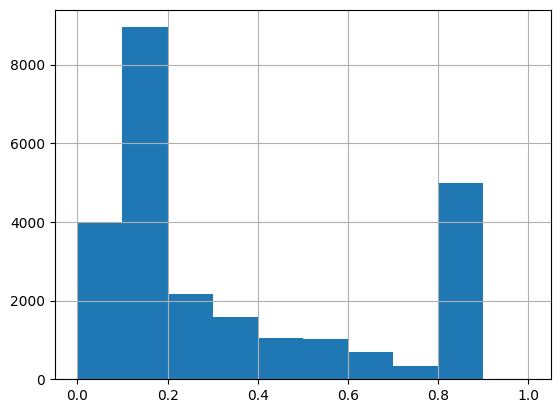

In [10]:
ts("doos").hist()

In [6]:
import torch
vec = ts.embedder.encode("serendipity")
vec = torch.as_tensor(vec).double()
sims = pd.Series(ts.rank_vector(vec), index=ts.space.index, name=ts.id)
sims.sort_values()[::-1][:100]

object_number
1987-0233          1.000000
1987-0228_4-6      1.000000
1987-0228_0-6      1.000000
1987-0237          1.000000
1987-1169_0-7      1.000000
                     ...   
6619               0.861489
1987-1488_12-12    0.851002
2017-0022          0.850223
1994-0074          0.849230
2008-0016_2-3      0.848700
Name: TextEmbeddingSeacher0, Length: 100, dtype: float64

In [9]:
dmg.loc[sims.sort_values()[::-1].index[:100]].coll.get_texts()

object_number
1987-0233                                               siermotief
1987-0228_4-6                                           siermotief
1987-0228_0-6                                           siermotief
1987-0237                                               siermotief
1987-1169_0-7                                           siermotief
                                       ...                        
1502_09-11       verzameling van  en champagneglas gemaakt van ...
3957               verzameling van  en trapaanzet gemaakt van  en 
1502_08-11       verzameling van  en champagneglas gemaakt van ...
3959                 verzameling van  en vaas gemaakt van  en hout
4147_1-3         verzameling van  en franje gemaakt van  en zij...
Length: 1000, dtype: object

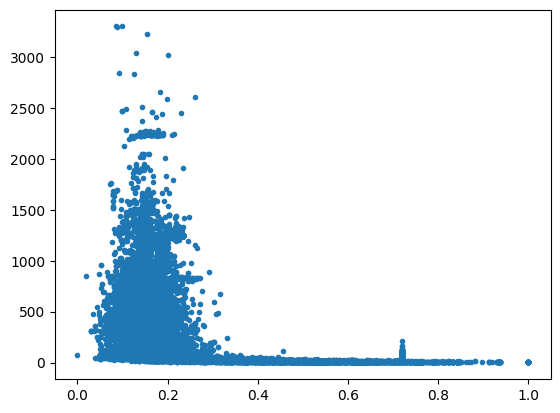

In [8]:
import matplotlib.pyplot as plt
plt.plot(
    list(sims.sort_values()[::-1]),
    dmg.coll.get_texts().apply(len).loc[sims.sort_values()[::-1].index],
    "."
)